# 机器学习实验三：参数估计 & 非参数估计
## 罗瑞 2210529

## 实验要求
**基本要求**
  
生成两个各包含 N=1000 个二维随机向量的数据集合$X_1$和$X_2$,数据集合中随机向量来自于三个分布模型，分别满足均值向量$\mu_1$=[1,4], $\mu_2$=[4,1], $\mu_3$=[8,4]和协方差矩阵$D_1$=$D_2$=$D_3$=2$I$,其中$I$是2*2的单位矩阵。
在生成数据集合$X_1$时，假设来自三个分布模型的先验概率相同;
而在生成数据集合$X_2$时，先验概率如下:$p(w_1)=0.6,p(w_2)=0.3,p(w_3)=0.1$


在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。

**中级要求**

在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

**高级要求**

在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计结果

## 1.基本要求实现


### 1.1数据集合$X_1$和$X_2$的生成和展示

这里我直接使用np.random.choice 生成分类标签，例如samples_X1 类型就是一个形状为(1000,)的numpy.ndarray 的一维数组，其中每个元素是整数，取值为 1, 2, 或 3，对应三个类别；使用np.random.multivariate_normal（多元正态分布随机分布）生成样本数据，对于每个类别，我按照题目要求进行数据生成。比如类别samples==1,生成数据时指定了分布的均值向量，如mu1 = [1, 4]，cov = 2 * np.eye(2)
，以及size=np.sum(samples_X1 == 1) 。

这样使用工具numpy就保证了在一个数据集中，数据符合三种类别的要求，同时保证了各自服从三个分布，互不影响。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 设置参数
mu1 = np.array([1, 4])
mu2 = np.array([4, 1])
mu3 = np.array([8, 4])
cov = 2 * np.eye(2)  # 2 * I

N = 1000  # 每个数据集的样本数

# 生成数据集 X1（先验概率相同）
p1_X1, p2_X1, p3_X1 = 1/3, 1/3, 1/3
samples_X1 = np.random.choice([1, 2, 3], size=N, p=[p1_X1, p2_X1, p3_X1])
X1_class1 = np.random.multivariate_normal(mu1, cov, np.sum(samples_X1 == 1))
X1_class2 = np.random.multivariate_normal(mu2, cov, np.sum(samples_X1 == 2))
X1_class3 = np.random.multivariate_normal(mu3, cov, np.sum(samples_X1 == 3))

# 生成数据集 X2（不同先验概率）
p1_X2, p2_X2, p3_X2 = 0.6, 0.3, 0.1
samples_X2 = np.random.choice([1, 2, 3], size=N, p=[p1_X2, p2_X2, p3_X2])
X2_class1 = np.random.multivariate_normal(mu1, cov, np.sum(samples_X2 == 1))
X2_class2 = np.random.multivariate_normal(mu2, cov, np.sum(samples_X2 == 2))
X2_class3 = np.random.multivariate_normal(mu3, cov, np.sum(samples_X2 == 3))

## 分别合并X1,X2不同类别的测试数据
X1 = np.vstack((X1_class1, X1_class2, X1_class3))
X2 = np.vstack((X2_class1, X2_class2, X2_class3))

## 分别按照X1，X2数据形状设置标签，便于后续测试精度
# 设置 X1 的标签
S_x1 = np.concatenate([
    np.full(len(X1_class1), 1),  # 类别1标签
    np.full(len(X1_class2), 2),  # 类别2标签
    np.full(len(X1_class3), 3)   # 类别3标签
])

#  X2 
S_x2 = np.concatenate([
    np.full(len(X2_class1), 1),  # 类别1标签
    np.full(len(X2_class2), 2),  # 类别2标签
    np.full(len(X2_class3), 3)   # 类别3标签
])


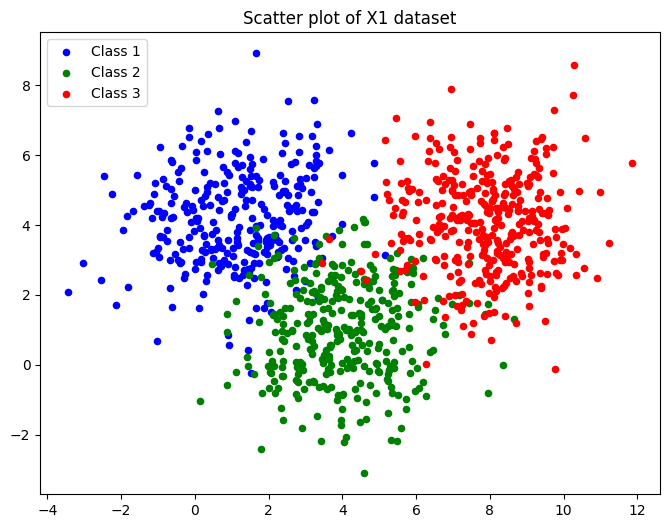

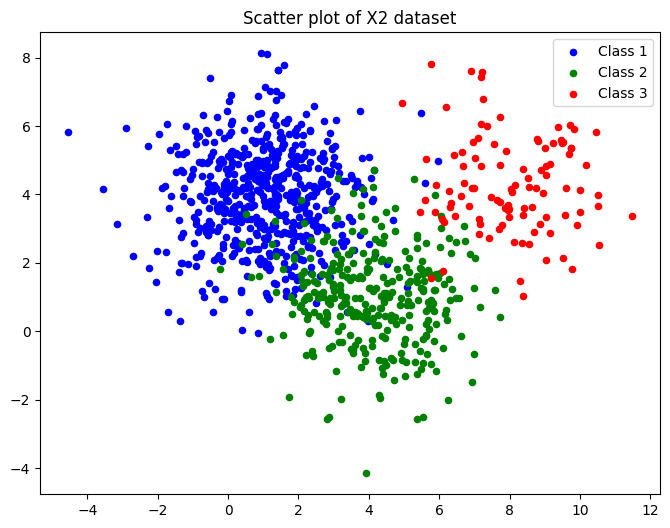

In [3]:
def plot_scatter(X_class1, X_class2, X_class3, title):
    """
    绘制数据集散点图
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X_class1[:, 0], X_class1[:, 1], c='blue', label='Class 1', s=20)
    plt.scatter(X_class2[:, 0], X_class2[:, 1], c='green', label='Class 2', s=20)
    plt.scatter(X_class3[:, 0], X_class3[:, 1], c='red', label='Class 3', s=20)
    plt.legend()
    plt.title(title)
    plt.show()

# 使用函数绘制 X1 和 X2 的散点图
plot_scatter(X1_class1, X1_class2, X1_class3, title='Scatter plot of X1 dataset')
plot_scatter(X2_class1, X2_class2, X2_class3, title='Scatter plot of X2 dataset')




### 1.2分类实验与结果分析

问题中已说明数据的生成是基于三个已知的分布。因此，分类时我基于这些已知的先验知识进行。对于似然率测试规则” ，我只需要考虑先验知识，而“最大后验概率规则”就需要采取不同的分类策略，需要求出最大的后验概率，从而得出对应的类别。

#### 1.2.1 似然率测试规则(LRT)
似然率测试基于每个类别的条件概率密度$p(x|\theta)$来分类。对样本$x$,我们计算在各个分布模型下的似然值：
对于每个类别$w_i$,概率密度函数为：

$$p(x|w_i)=\frac1{2\pi|\Sigma_i|^{1/2}}\exp\left(-\frac12(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)\right)$$

其中$\mu_i$是均值向量，$\Sigma_i$是协方差矩阵。选取$p(x|w_i)$ 最大的情况对应的类别便是LRT的分类结果。

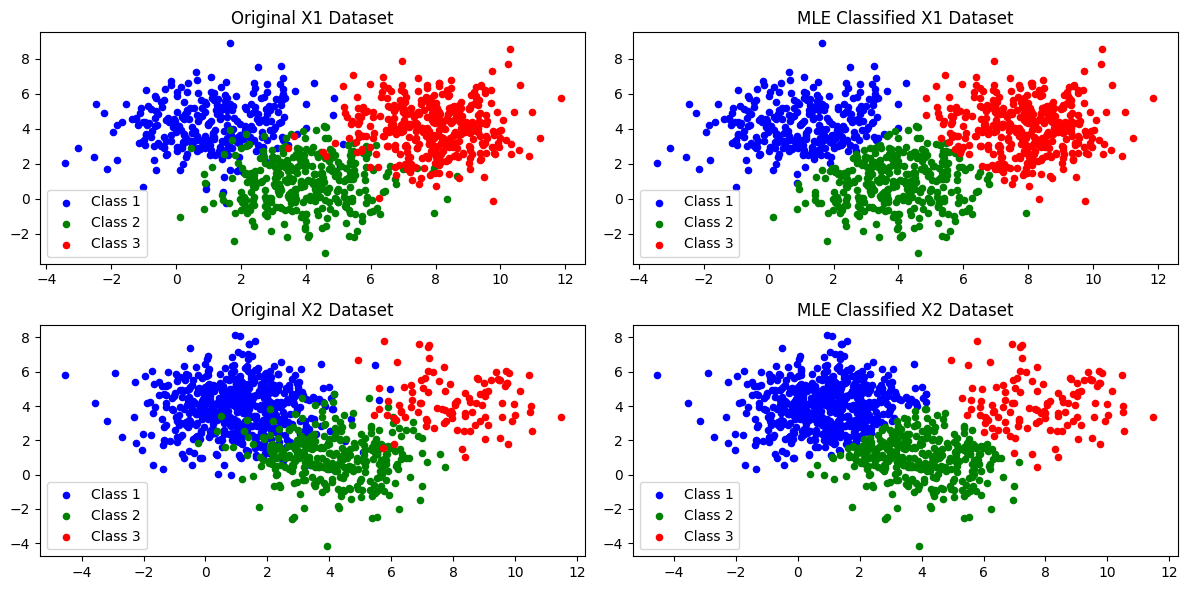

X1 分类错误率: 0.062
X2 分类错误率: 0.086


In [4]:
# 实现多元正态分布的条件概密函数
def P(x, mu, inv_cov, det_cov):
    diff = x - mu
    exponent = -0.5 * np.dot(np.dot(diff.T, inv_cov), diff)
    coeff = 1 / (2 * np.pi * np.sqrt(det_cov))
    return coeff * np.exp(exponent)

def classify(X, mu1, mu2, mu3, cov):
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    # 对每个样本，分别计算它在三个正态分布下的概率密度
    p1 = np.array([P(x, mu1, inv_cov, det_cov) for x in X])
    p2 = np.array([P(x, mu2, inv_cov, det_cov) for x in X])
    p3 = np.array([P(x, mu3, inv_cov, det_cov) for x in X])
 
    # 堆叠概率，用于计算最大概率对应的分类标签
    probabilities = np.vstack([p1, p2, p3]) 

    # 转置使其形状为 (N_samples, 3)
    probabilities = probabilities.T
    
    y_pred = np.argmax(probabilities, axis=1) +1 # 找出每行最大值的索引，本来索引是从0开始的，加1才嫩得到类别标签
     
    # 按照分类结果返回数据，便于后续可视化
    yX_class1=X[y_pred == 1]
    yX_class2=X[y_pred == 2]
    yX_class3=X[y_pred == 3]
   
    return y_pred, yX_class1,yX_class2,yX_class3

# 使用MLE分类进行分类
y_pred_X1, yX1_class1, yX1_class2, yX1_class3 = classify(X1, mu1, mu2, mu3, cov)
y_pred_X2, yX2_class1, yX2_class2, yX2_class3 = classify(X2, mu1, mu2, mu3, cov)


# 数据集X1和X2分别的分类对比
plt.figure(figsize=(12, 6))
# X1 数据集
plt.subplot(2, 2, 1)  # 2行2列的第1个子图
plt.scatter(X1_class1[:, 0], X1_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(X1_class2[:, 0], X1_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(X1_class3[:, 0], X1_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('Original X1 Dataset')
plt.legend()
# X1 MLE 分类结果
plt.subplot(2, 2, 2)  # 2行2列的第2个子图
plt.scatter(yX1_class1[:, 0], yX1_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(yX1_class2[:, 0], yX1_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(yX1_class3[:, 0], yX1_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('MLE Classified X1 Dataset')
plt.legend()
# X2 数据集
plt.subplot(2, 2, 3)  # 2行2列的第3个子图
plt.scatter(X2_class1[:, 0], X2_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(X2_class2[:, 0], X2_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(X2_class3[:, 0], X2_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('Original X2 Dataset')
plt.legend()
# X2 MLE 分类结果
plt.subplot(2, 2, 4)  # 2行2列的第4个子图
plt.scatter(yX2_class1[:, 0], yX2_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(yX2_class2[:, 0], yX2_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(yX2_class3[:, 0], yX2_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('MLE Classified X2 Dataset')
plt.legend()
# 绘图输出
plt.tight_layout()
plt.show()

# 计算分类错误率，(使用np工具mean）
error_rate_X1 = np.mean(y_pred_X1 != S_x1)
error_rate_X2 = np.mean(y_pred_X2 != S_x2)

print(f"X1 分类错误率: {error_rate_X1}")
print(f"X2 分类错误率: {error_rate_X2}")

#### 1.2.2 最大后验分类规则
为了使用最大后验概率（MAP）规则进行分类，首先需要定义先验概率，然后根据先验概率和似然概率来计算后验概率。
为了实现MAP 分类，需要：

**计算每个类别的先验概率**：通常通过每个类别的样本数量除以总样本数来计算，但是本题目我直接带入生成数据的先验概率即可。

**计算后验概率**：通过贝叶斯定理，后验概率与先验概率和似然概率成正比，对每个样本，选择具有最高后验概率的类别作为预测结果，从而得到对应的类别。


In [5]:
def map_classify(X, mu1, mu2, mu3, cov, p_prior):
    # 计算协方差矩阵的逆和行列式
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    # 计算每个样本在每个类别下的后验概率
    posterior_probs = []
    
    for i, mu in enumerate([mu1, mu2, mu3]):
        p = np.array([P(x, mu, inv_cov, det_cov) for x in X])
        posterior_probs.append(p_prior[i] * p) 
    
    # 堆叠后验概率，用于计算最大后验概率对应的分类标签
    posterior_probs = np.vstack(posterior_probs).T
    
    # 选择最大后验概率的类别
    y_pred = np.argmax(posterior_probs, axis=1) + 1  
    
    # 按照分类结果返回数据，便于后续可视化
    yX_class1 = X[y_pred == 1]
    yX_class2 = X[y_pred == 2]
    yX_class3 = X[y_pred == 3]
   
    return y_pred, yX_class1, yX_class2, yX_class3

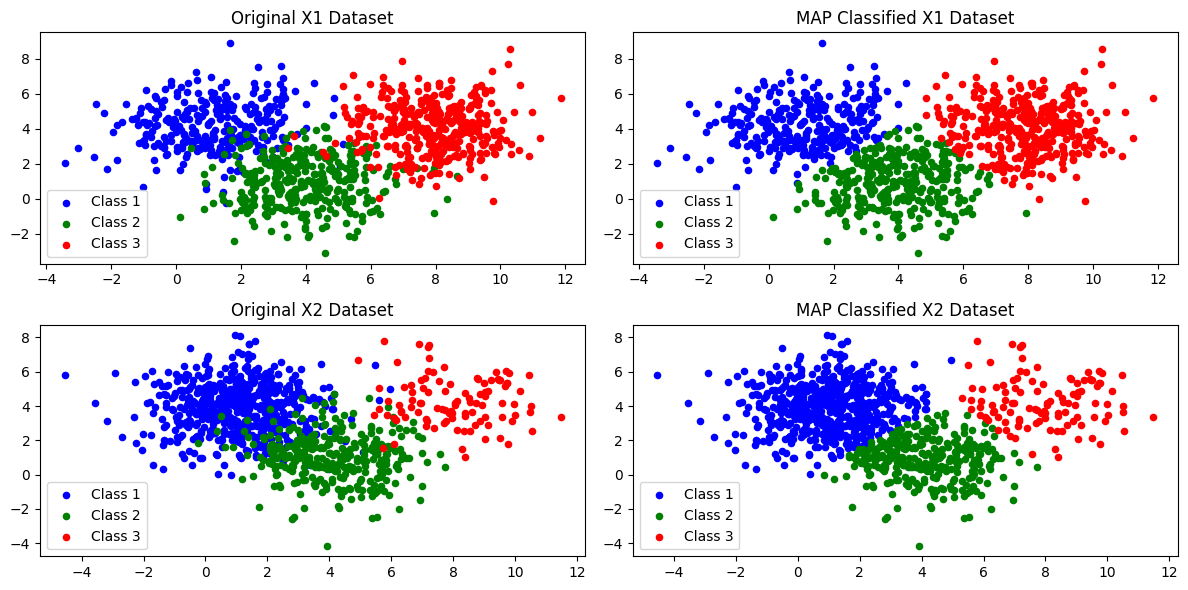

X1 分类错误率: 0.062
X2 分类错误率: 0.077


In [6]:
# 每个类别的样本先验概率已得知
px1_prior=[1/3, 1/3, 1/3]
px2_prior=[0.6, 0.3, 0.1]

# 使用 MAP 分类进行分类
y_pred_X1, yX1_class1, yX1_class2, yX1_class3 = map_classify(X1, mu1, mu2, mu3, cov, px1_prior)
y_pred_X2, yX2_class1, yX2_class2, yX2_class3 = map_classify(X2, mu1, mu2, mu3, cov, px2_prior)

# 分类效果可视化
plt.figure(figsize=(12, 6))

# X1 数据集
plt.subplot(2, 2, 1)  # 2行2列的第1个子图
plt.scatter(X1_class1[:, 0], X1_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(X1_class2[:, 0], X1_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(X1_class3[:, 0], X1_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('Original X1 Dataset')
plt.legend()

# X1 MAP 分类结果
plt.subplot(2, 2, 2)  # 2行2列的第2个子图
plt.scatter(yX1_class1[:, 0], yX1_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(yX1_class2[:, 0], yX1_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(yX1_class3[:, 0], yX1_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('MAP Classified X1 Dataset')
plt.legend()

# X2 数据集
plt.subplot(2, 2, 3)  # 2行2列的第3个子图
plt.scatter(X2_class1[:, 0], X2_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(X2_class2[:, 0], X2_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(X2_class3[:, 0], X2_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('Original X2 Dataset')
plt.legend()

# X2 MAP 分类结果
plt.subplot(2, 2, 4)  # 2行2列的第4个子图
plt.scatter(yX2_class1[:, 0], yX2_class1[:, 1], c='blue', label='Class 1', s=20)
plt.scatter(yX2_class2[:, 0], yX2_class2[:, 1], c='green', label='Class 2', s=20)
plt.scatter(yX2_class3[:, 0], yX2_class3[:, 1], c='red', label='Class 3', s=20)
plt.title('MAP Classified X2 Dataset')
plt.legend()

#绘图
plt.tight_layout()
plt.show()

# 计算分类错误率
error_rate_X1 = np.mean(y_pred_X1 != S_x1)
error_rate_X2 = np.mean(y_pred_X2 != S_x2)

print(f"X1 分类错误率: {error_rate_X1}")
print(f"X2 分类错误率: {error_rate_X2}")

#### 1.2.3 结果分析
对于数据集X1:

似然率测试规则分类错误率: 0.062

最大后验分类规则分类错误率：0.062

对于数据集X2：

似然率测试规则分类错误率: 0.086

最大后验分类规则分类错误率：0.077

分析之前首先需要再次明确：**X1的数据来自三个分布模型的先验概率是相同的，而X2的数据来自三个分布模型的先验概率呈现差异分布**，
对于这个实验结果：

在数据集X1中，**先验概率相同**，在先验概率均等的情况下，加入先验信息并不会显著影响分类性能，**此时最大后验分类规则退化为似然率测试规则**，**两者的性能相同**，因此似然率测试规则和最大后验分类规则的错误率肯定是一样的。

在数据集X2中，**先验概率不同**，最大后验分类规则**有效利用了类别的先验概率**，最大后验分类规则能够更好地调整对各类的区分，从而**显著降低了错误率**，证明在先验概率不均等时，最大后验分类规则具有更强的分类能力。



## 2.中级要求实现

### 2.1 高斯核函数定义以及分类函数的定义（实现模型的训练和预测）

**训练阶段**：
训练数据（X_train, y_train）：
使用训练数据集 X_train 和相应的标签 y_train 进行核密度估计模型的训练。首先进行核密度估计：对于每个类别 c，根据属于该类别的训练数据样本来计算核密度估计。具体来说，X_train[y_train == c] 提取出训练集中属于类别 c 的所有样本，使用函数 kernel_density_estimation(X_train[y_train == c], x, h) 计算给定测试样本 x 在类别 c 上的核密度估计值。


**测试阶段**：
测试数据（X_test）：对于每个测试样本 x，计算其在每个类别下的概率密度。
对于每个类别 c，计算其在类别 c 下的核密度 p(x | c)，计算完每个类别的核密度后，选择具有最大密度的类别作为预测结果，预测该样本属于具有最高似然性的类别；对于最大后验概率估计，在此基础上乘上先验概率再进行最大判断即可，这里和前面一样，也是使用np.argmax(densities) 返回具有最大密度的类别索引。

In [7]:
from sklearn.model_selection import KFold

# 核密度估计函数
def kernel_density_estimation(X, x, h):
    n, d = X.shape
    # 使用高斯核密度估计
    K = np.sum(np.exp(-0.5 * np.sum((X - x)**2, axis=1) / (h**2)))
    return K / (n * (h**d) * np.sqrt(2 * np.pi)**d)

# 似然率测试分类函数
def classify_likelihood(X_train, y_train, X_test, h, classes):
    predictions = []
    for x in X_test:
        densities = [kernel_density_estimation(X_train[y_train == c], x, h) for c in classes]
        predictions.append(np.argmax(densities) + 1)  # 类别标签从1开始
    return np.array(predictions)

# 最大后验概率分类函数
def classify_map(X_train, y_train, X_test, h, classes, priors):
    predictions = []
    for x in X_test:
        posteriors = [kernel_density_estimation(X_train[y_train == c], x, h) * priors[c] for c in classes]
        predictions.append(np.argmax(posteriors) + 1)  # 类别标签从1开始
    return np.array(predictions)

### 2.2 划分数据集，实现k-折交叉验证逻辑，执行交叉验证，输出结果

In [8]:
# 交叉验证找到最优 h
def cross_validation(X, y, h_values, rule, priors=None, folds=100, random_state=None):
    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)  # 设置随机种子
    best_h = None
    min_error_rate = float('inf')
    
    for h in h_values:
        error_rates = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if rule == 'likelihood':
                y_pred = classify_likelihood(X_train, y_train, X_test, h, np.unique(y))
            elif rule == 'map':
                y_pred = classify_map(X_train, y_train, X_test, h, np.unique(y), priors)
            
            error_rate = np.mean(y_pred != y_test)
            error_rates.append(error_rate)
        
        avg_error_rate = np.mean(error_rates)
        # 使用字符串格式化控制显示的小数位数
        avg_error_rate = np.round(avg_error_rate, 4)
        print(f"h={h}, 平均错误率: {avg_error_rate}")
        if avg_error_rate < min_error_rate:
            min_error_rate = avg_error_rate
            best_h = h
    
    return best_h, min_error_rate

# 核密度估计 h 值
h_values = [0.1, 0.5, 1, 1.5, 2]

# 先验概率
priors_X2 = {1: 0.6, 2: 0.3, 3: 0.1} 
priors_X1 = {1: 1/3, 2: 1/3, 3: 1/3}

#  X1 进行交叉验证，使用似然率测试规则
print("X1 - 似然率测试规则")
best_h_X1_likelihood, error_rate_X1_likelihood = cross_validation(X1, S_x1, h_values, 'likelihood', random_state=42  )

#  X1 进行交叉验证，使用大后验概率
print("X1 - 最大后验概率规则")
best_h_X1_map, error_rate_X1_map = cross_validation(X1, S_x1, h_values, 'map', priors_X1, random_state=42)

#  X2 ，似然率测试
print("X2 - 似然率测试规则")
best_h_X2_likelihood, error_rate_X2_likelihood = cross_validation(X2, S_x2, h_values, 'likelihood', random_state=42  )

#  X2 ，最大后验概率
print("X2 - 最大后验概率规则")
best_h_X2_map, error_rate_X2_map = cross_validation(X2, S_x2, h_values, 'map', priors_X2, random_state=42)

# 打印
print(f"X1 最优 h（似然率测试规则）: {best_h_X1_likelihood}, 错误率: {error_rate_X1_likelihood}")
print(f"X1 最优 h（最大后验概率规则）: {best_h_X1_map}, 错误率: {error_rate_X1_map}")
print(f"X2 最优 h（似然率测试规则）: {best_h_X2_likelihood}, 错误率: {error_rate_X2_likelihood}")
print(f"X2 最优 h（最大后验概率规则）: {best_h_X2_map}, 错误率: {error_rate_X2_map}")


X1 - 似然率测试规则
h=0.1, 平均错误率: 0.094
h=0.5, 平均错误率: 0.063
h=1, 平均错误率: 0.061
h=1.5, 平均错误率: 0.061
h=2, 平均错误率: 0.062
X1 - 最大后验概率规则
h=0.1, 平均错误率: 0.094
h=0.5, 平均错误率: 0.063
h=1, 平均错误率: 0.061
h=1.5, 平均错误率: 0.061
h=2, 平均错误率: 0.062
X2 - 似然率测试规则
h=0.1, 平均错误率: 0.091
h=0.5, 平均错误率: 0.084
h=1, 平均错误率: 0.085
h=1.5, 平均错误率: 0.085
h=2, 平均错误率: 0.082
X2 - 最大后验概率规则
h=0.1, 平均错误率: 0.089
h=0.5, 平均错误率: 0.069
h=1, 平均错误率: 0.068
h=1.5, 平均错误率: 0.074
h=2, 平均错误率: 0.1
X1 最优 h（似然率测试规则）: 1, 错误率: 0.061
X1 最优 h（最大后验概率规则）: 1, 错误率: 0.061
X2 最优 h（似然率测试规则）: 2, 错误率: 0.082
X2 最优 h（最大后验概率规则）: 1, 错误率: 0.068


分析：

对于X1 数据集：

·似然率测试规则：最优的带宽参数$h=1$,错误率为 0.061。

·最大后验慨率规则：最优的带宽参数$h=1$,错误率为 0.061。

这表明在 X1 数据集上，使用$h=1$的高斯核估计效果最优。由于X1数据集类别先验概率一致，故两个规则的表现是一样的。

对于X2 数据集：

·似然率测试规则：最优的带宽参数$h=2$,错误率为0.082。

·最大后验慨率规则：最优的带宽参数$h=1$,错误率为0.068。

这表明在 X2 数据集上，似然率测试规则选择的带宽是$h=2$,而最大后验概率规则选择的带宽
是$h=1$。不同的规则对带宽选择有不同的敏感性。

## 3 高级要求实现

在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计结果，这里我直接输出在各个k值下，所有类别的概率密度综合分布图。

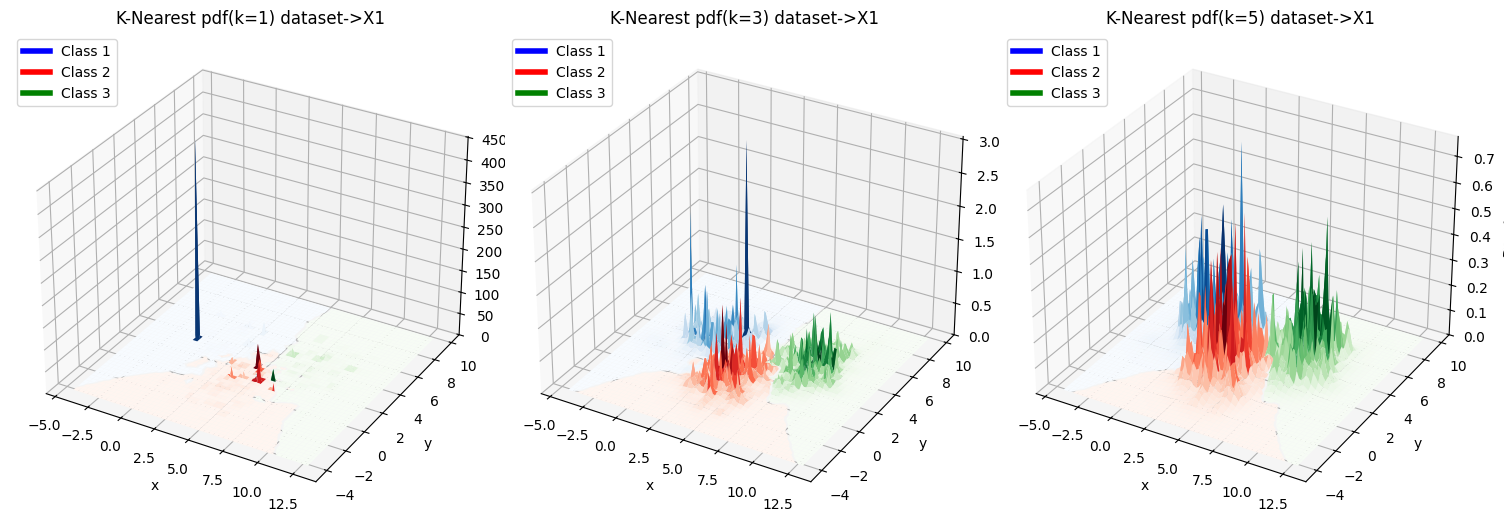

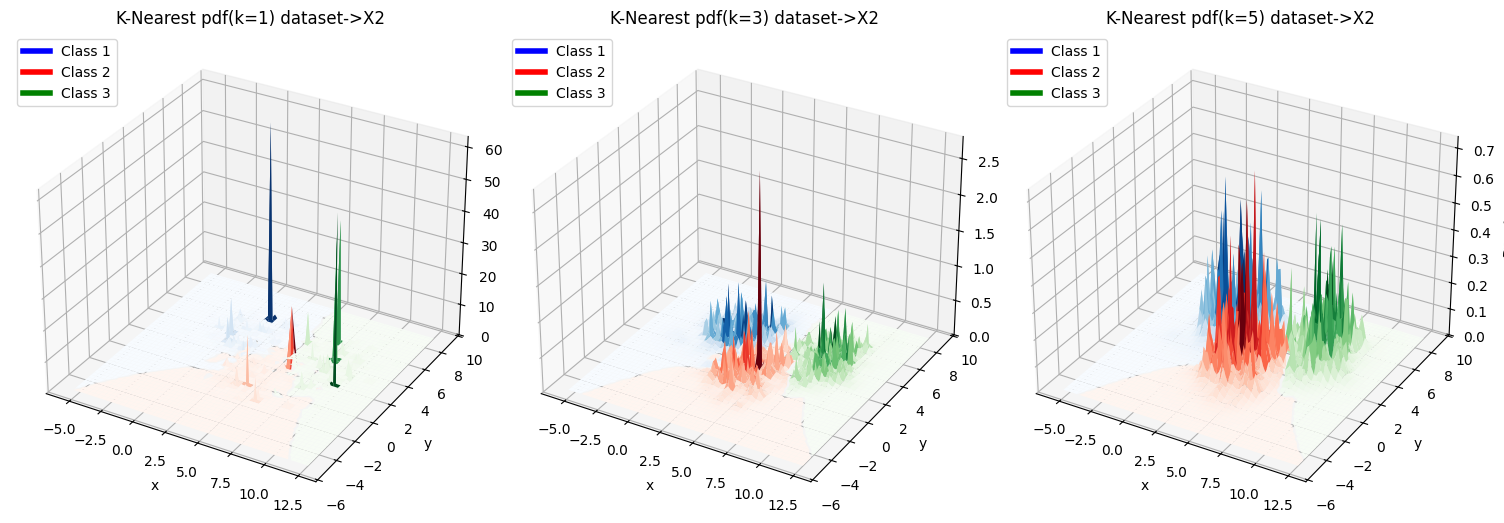

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import math


# 计算欧几里得距离：单个点到数据集 X 中所有点的距离
def euclidean_distance(point, X):
    distances = []
    for i in range(len(X)):
        # 计算二维坐标上的距离平方
        distance = np.sum((X[i] - point) ** 2)
        distances.append(np.sqrt(distance))  # 取平方根得到欧几里得距离
    return distances
    
# k-近邻密度估计
def knn_density_estimation(X, k, X_grid):
    N = len(X)  # 样本数量
    densities = np.zeros(X_grid.shape[0])  # 存储每个网格点的密度
    
    for i, point in enumerate(X_grid):
        # 计算当前网格点与所有训练数据点的距离
        distances = euclidean_distance(point, X)
        
        # 找到距离最近的k个邻居的距离
        nearest_neighbors_indices = np.argsort(distances)[:k]
        nearest_neighbors_distances = [distances[idx] for idx in nearest_neighbors_indices]
        
        # 假设密度为 k / (N * h^2)，其中 h 为最近 k 个点的平均距离
        h = np.mean(nearest_neighbors_distances)  # 平均距离
        V = math.pi * (h ** 2)  # 面积计算
        density = k / (N * V)  # 密度估计
        densities[i] = density
    
    return densities

# 生成用于绘制密度估计的网格数据
def generate_grid(X, num_points=100):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.mgrid[x_min:x_max:num_points*1j, y_min:y_max:num_points*1j]
    return np.vstack([xx.ravel(), yy.ravel()]).T, xx, yy

# 设置k值
k_values = [1, 3, 5]



## X1数据集
# 网格数据生成
X_grid, xx, yy = generate_grid(X1, num_points=100)

# 3D 绘制
fig = plt.figure(figsize=(15, 12))

for k in k_values:
    ax = fig.add_subplot(1, len(k_values), k_values.index(k) + 1, projection='3d')

    # 计算各类别的密度
    density1 = knn_density_estimation(X1_class1, k, X_grid)
    density1_reshaped = density1.reshape(xx.shape)
    
    density2 = knn_density_estimation(X1_class2, k, X_grid)
    density2_reshaped = density2.reshape(xx.shape)
    
    density3 = knn_density_estimation(X1_class3, k, X_grid)
    density3_reshaped = density3.reshape(xx.shape)
    
    # 找到每个点上密度最高的类别，并只保留该类别的密度值
    max_density = np.maximum(np.maximum(density1, density2), density3)
    
    # 选择优先显示类别
    density1_masked = np.where((density1 == max_density) & (density1 >= density2) & (density1 >= density3), density1, np.nan)
    density2_masked = np.where((density2 == max_density) & (density2 > density1) & (density2 >= density3), density2, np.nan)
    density3_masked = np.where((density3 == max_density) & (density3 > density1) & (density3 > density2), density3, np.nan)

    # 重塑为二维数组
    density1_masked = density1_masked.reshape(xx.shape)
    density2_masked = density2_masked.reshape(xx.shape)
    density3_masked = density3_masked.reshape(xx.shape)
    
    # 绘制类别1、2、3的密度值
    ax.plot_surface(xx, yy, density1_masked, cmap='Blues', edgecolor='none')
    ax.plot_surface(xx, yy, density2_masked, cmap='Reds', edgecolor='none')
    ax.plot_surface(xx, yy, density3_masked, cmap='Greens', edgecolor='none')

    # 设置标题和轴标签
    ax.set_title(f"K-Nearest pdf(k={k}) dataset->X1")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Density")
    ax.set_zlim(0, np.max(max_density))  
    # 图例
    custom_lines = [Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    ax.legend(custom_lines, ['Class 1', 'Class 2', 'Class 3'], loc='upper left')
plt.tight_layout()
plt.show()


## X2数据集
# 网格数据生成
X_grid, xx, yy = generate_grid(X2, num_points=100)

# 3D 绘制
fig = plt.figure(figsize=(15, 12))

for k in k_values:
    ax = fig.add_subplot(1, len(k_values), k_values.index(k) + 1, projection='3d')

    # 计算各类别的密度
    density1 = knn_density_estimation(X1_class1, k, X_grid)
    density1_reshaped = density1.reshape(xx.shape)
    
    density2 = knn_density_estimation(X1_class2, k, X_grid)
    density2_reshaped = density2.reshape(xx.shape)
    
    density3 = knn_density_estimation(X1_class3, k, X_grid)
    density3_reshaped = density3.reshape(xx.shape)
    
    # 找到每个点上密度最高的类别，并只保留该类别的密度值
    max_density = np.maximum(np.maximum(density1, density2), density3)
    
    # 选择优先显示类别
    density1_masked = np.where((density1 == max_density) & (density1 >= density2) & (density1 >= density3), density1, np.nan)
    density2_masked = np.where((density2 == max_density) & (density2 > density1) & (density2 >= density3), density2, np.nan)
    density3_masked = np.where((density3 == max_density) & (density3 > density1) & (density3 > density2), density3, np.nan)

    # 重塑为二维数组
    density1_masked = density1_masked.reshape(xx.shape)
    density2_masked = density2_masked.reshape(xx.shape)
    density3_masked = density3_masked.reshape(xx.shape)

    # 绘制类别1、2、3的密度值
    ax.plot_surface(xx, yy, density1_masked, cmap='Blues', edgecolor='none')
    ax.plot_surface(xx, yy, density2_masked, cmap='Reds', edgecolor='none')
    ax.plot_surface(xx, yy, density3_masked, cmap='Greens', edgecolor='none')

    # 设置标题和轴标签
    ax.set_title(f"K-Nearest pdf(k={k}) dataset->X2")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Density")
    ax.set_zlim(0, np.max(max_density))  
    # 图例
    custom_lines = [Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    ax.legend(custom_lines, ['Class 1', 'Class 2', 'Class 3'], loc='upper left')
plt.tight_layout()
plt.show()


两个数据集对应的根据估计结果的概率密度函数分布图如上。可以观察到，无论是哪个数据集，当k取3或5时有较直观的函数分布，也据此可以推测，此时的k=3或k=5训练的模型用来分类才具有更好的分类效果。实际上，我的分布图将三种类别的概密图画在一张图上并只显示最高概率，这实际上已经完成了直观的分类结果。